In [1]:
import os
import re
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [2]:
dataset_path = "./dataset_papers/"
json_path = "parsed_citations.json"
nodes = [os.path.splitext(file)[0] for file in os.listdir(dataset_path)]
G = nx.DiGraph()

titles = {}
abstracts = {}
papers = os.listdir(dataset_path)
for paper in papers:
    paper_path = os.path.join(dataset_path, paper)
    titlee, abstracte = None, None
    with open(os.path.join(paper_path, "title.txt"), "r", encoding="utf-8") as f:
        titlee = f.read().strip()
    with open(os.path.join(paper_path, "abstract.txt"), "r", encoding="utf-8") as f:
        abstracte = f.read().strip()
    G.add_node(paper, title=titlee, abstract=abstracte)
    titles[paper] = titlee
    abstracts[paper] = abstracte

all_titles = {node[0]: node[1]["title"].upper() for node in G.nodes(data=True)}
title_to_paper = {}
for paper, title in all_titles.items():
    title = re.sub(r"\s+", " ", title)
    title = re.sub(r"[^A-Z0-9]", "", title)
    title = re.sub(r"\s+", " ", title)
    title = title.upper()
    title_to_paper[title] = paper

In [3]:
def title_match(title, title_to_paper):
    if title in title_to_paper:
        # print(f"Exact match found for {title}")
        return title_to_paper[title]
    # best_match = get_close_matches(title, title_to_paper.keys(), n=1, cutoff=0.9)
    # if best_match:
    #     print(f"Best match for {title}: {best_match}")
    #     return title_to_paper[best_match[0]]
    # print(f"No close match found for {title}")
    return None

def add_edges(G, paper_id, citations, title_to_paper):
    for citation in citations:
        cited_paper_id = citation["key"]
        cited_paper_title = citation["title"].upper()
        cited_paper_title = re.sub(r"\s+", " ", cited_paper_title)
        cited_paper_title = re.sub(r"[^A-Z0-9]", "", cited_paper_title)
        cited_paper_title = re.sub(r"\s+", " ", cited_paper_title)
        cited_paper_title = cited_paper_title.upper()
        best_match_id = title_match(cited_paper_title, title_to_paper)
        if best_match_id:
            G.add_edge(paper_id, best_match_id)
            continue
        # else:
        #     # print(f"Warning: No match found for {cited_paper_title} in {paper_id}.")
        #     G.add_node(cited_paper_id, title=cited_paper_title)
        #     G.add_edge(paper_id, cited_paper_id)
        #     title_to_paper[cited_paper_title] = cited_paper_id

def visualize_graph(G, output_path):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold")
    plt.title("Citation Network")
    plt.savefig(output_path)
    plt.show()

In [ ]:
with open(json_path, "r", encoding="utf-8") as f:
    citations_data = json.load(f)
    for paper in citations_data:
        # print(f"Processing paper: {paper['paper_id']}")
        paper_id = paper["paper_id"]
        citations = paper["citations"]
        add_edges(G, paper_id, citations, title_to_paper)

Number of edges:  29392
Number of isolated nodes:  438
Average in-degree:  4.490756302521008
Average out-degree:  4.490756302521008


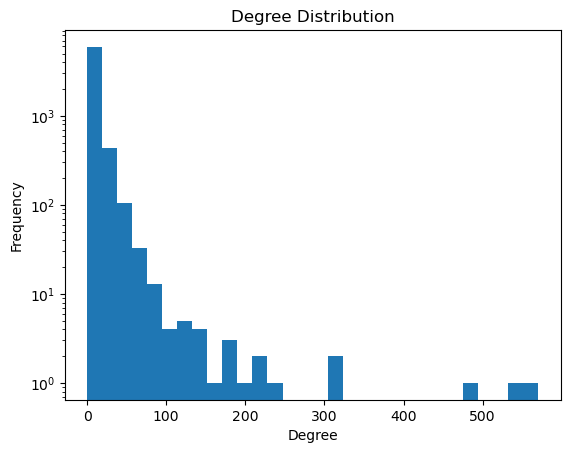

In [5]:
# The number of edges in the graph.
# Number of isolated nodes in the graph.
# The average degree (in-degree, out-degree). Plot a histogram of the degrees of nodes.
# Diameter of the graph.
def graph_statistics(G):
    print("Number of edges: ", G.number_of_edges())
    print("Number of isolated nodes: ", len(list(nx.isolates(G))))
    # print("Diameter of the graph: ", nx.diameter(G))
    print("Average in-degree: ", sum(dict(G.in_degree()).values()) / G.number_of_nodes())
    print("Average out-degree: ", sum(dict(G.out_degree()).values()) / G.number_of_nodes())
    degrees = [d for n, d in G.degree()]
    plt.hist(degrees, bins=30)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.yscale("log")
    plt.show()
graph_statistics(G)

In [6]:
from sentence_transformers import SentenceTransformer

feature_model = SentenceTransformer('all-MiniLM-L6-v2')
features = {}
for paper_id in papers:
    text = titles[paper_id] + " " + abstracts[paper_id]
    features[paper_id] = feature_model.encode(text)  # 384-d vector

/users/ug22/anileshbansal/miniconda3/envs/cs768/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [8]:
def negative_sampling(G, num_samples, edges, node_to_idx):
    # edges = list(G.edges())
    all_nodes = [node_to_idx[node] for node in G.nodes()]
    existing_edges = set((min(u, v), max(u, v)) for u, v in edges)
    
    neg_edges = []
    while len(neg_edges) < num_samples:
        u, v = random.sample(all_nodes, 2)
        u, v = min(u, v), max(u, v)
        if (u, v) not in existing_edges:
            neg_edges.append((u, v))
    
    return neg_edges

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = GraphSAGE(in_channels=384, hidden_channels=128, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

node_to_idx = {node: idx for idx, node in enumerate(G.nodes)}
edges = []
for src, dst in G.edges:
    edges.append((node_to_idx[src], node_to_idx[dst]))

In [10]:
def train(model, optimizer, features, edge_index, epochs=10, batch_size=256):
    model.train()
    pos_edges = edges.copy()
    for epoch in range(epochs):
        epoch_loss = 0
        random.shuffle(pos_edges)
        for i in range(0, len(pos_edges), batch_size):
            pos_batch = pos_edges[i:i + batch_size]
            src_pos, dst_pos = zip(*pos_batch)
            src_pos = torch.tensor(src_pos, dtype=torch.long).to(device)
            dst_pos = torch.tensor(dst_pos, dtype=torch.long).to(device)
            neg_edges = negative_sampling(G, len(pos_batch), edges, node_to_idx)
            src_neg, dst_neg = zip(*neg_edges)
            src_neg = torch.tensor(src_neg, dtype=torch.long).to(device)
            dst_neg = torch.tensor(dst_neg, dtype=torch.long).to(device)
            h_all = model(features, edge_index)
            pos_score = (h_all[src_pos] * h_all[dst_pos]).sum(dim=1)
            neg_score = (h_all[src_neg] * h_all[dst_neg]).sum(dim=1)
            pos_labels = torch.ones(pos_score.size(0)).to(device)
            neg_labels = torch.zeros(neg_score.size(0)).to(device)
            scores = torch.cat([pos_score, neg_score], dim=0)
            labels = torch.cat([pos_labels, neg_labels], dim=0)
            loss = F.binary_cross_entropy_with_logits(scores, labels)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

In [11]:
features_tensor = torch.tensor(list(features.values()), dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
model = model.to(device)
features_tensor = features_tensor.to(device)
edge_index = edge_index.to(device)

# Train the model
train(model, optimizer, features_tensor, edge_index)

/tmp/ipykernel_1285485/963245250.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  features_tensor = torch.tensor(list(features.values()), dtype=torch.float)


Epoch 1/10, Loss: 64.3511
Epoch 2/10, Loss: 59.4998
Epoch 3/10, Loss: 58.2331
Epoch 4/10, Loss: 57.3485
Epoch 5/10, Loss: 56.5001
Epoch 6/10, Loss: 56.3714
Epoch 7/10, Loss: 56.0893
Epoch 8/10, Loss: 56.0011
Epoch 9/10, Loss: 55.6637
Epoch 10/10, Loss: 55.5580


In [15]:
@torch.no_grad()
def predict(model, x_all, edge_index, query_feature, top_k=5):
    model.eval()
    embeddings = model(x_all, edge_index)
    query_embedding = model(query_feature.unsqueeze(0), edge_index=torch.empty(2, 0).long())[0]
    cos_sim = F.cosine_similarity(query_embedding.unsqueeze(0), embeddings)
    topk_indices = cos_sim.topk(top_k).indices
    return topk_indices

In [16]:
def topK(title, abstract, k=5):
    query_feature = feature_model.encode(title + " " + abstract)
    query_feature = torch.tensor(query_feature, dtype=torch.float).to(device)
    top_k_indices = predict(model, features_tensor, edge_index, query_feature, top_k=k)
    top_k_papers = [list(G.nodes)[idx] for idx in top_k_indices.cpu().numpy()]
    return top_k_papers

title = "Graph Edit Distance with General Costs Using Neural Set Divergence"
abstract = """Graph Edit Distance (GED) measures the (dis-)similarity between two given graphs,
 in terms of the minimum-cost edit sequence that transforms one graph to the
 other. However, the exact computation of GED is NP-Hard, which has recently
 motivated the design of neural methods for GED estimation. However, they do not
 explicitly account for edit operations with different costs. In response, we propose
 GRAPHEDX, a neural GED estimator that can work with general costs specified
 for the four edit operations, viz., edge deletion, edge addition, node deletion and
 node addition. We first present GED as a quadratic assignment problem (QAP)
 that incorporates these four costs. Then, we represent each graph as a set of node
 and edge embeddings and use them to design a family of neural set divergence
 surrogates. We replace the QAP terms corresponding to each operation with their
 surrogates. Computing such neural set divergence require aligning nodes and
 edges of the two graphs. We learn these alignments using a Gumbel-Sinkhorn
 permutation generator, additionally ensuring that the node and edge alignments
 are consistent with each other. Moreover, these alignments are cognizant of both
 the presence and absence of edges between node-pairs. Experiments on several
 datasets, under a variety of edit cost settings, show that GRAPHEDX consistently
 outperforms state-of-the-art methods and heuristics in terms of prediction error."""

In [22]:
topK_papers = topK(title, abstract, k=5)
print("Top K papers:")
for paper in topK_papers:
    print(f"- {paper}: {titles[paper]}")

Top K papers:
- 2305.02200v2: Deep Graph Representation Learning and Optimization for Influence Maximization
- 2310.15865v2: Using Time-Aware Graph Neural Networks to Predict Temporal Centralities in Dynamic Graphs
- 2210.08189v2: Parameter-free Dynamic Graph Embedding for Link Prediction
- 2406.08649v2: MOTIVE: A Drug-Target Interaction Graph For Inductive Link Prediction
- 2211.13708v1: Reduction Algorithms for Persistence Diagrams of Networks: CoralTDA and PrunIT
